# Location-Based Social Network
Gowalla is a location-based social network where users "check in" to various locations. A check-in is the action of recording a user's physical presence at a specific real-world location, and a spot is the digital representation of that real-world location within the network. 

The dataset contains friend links and a complete check-in history for each user (with geographic coordinates).

Dataset source: https://snap.stanford.edu/data/loc-Gowalla.html

---

This notebook focuses on building a real-world link prediction pipeline, introducing:
* Temporal Dynamics: Using a time-based split to predict future links based on past data.
* Large-Scale Data Handling: Applying efficient EDA and sampling techniques suitable for a larger graph.
* Node Embedding: Training Node2Vec to automatically learn feature representations from the graph structure.
* Advanced Feature Engineering: Combining topological features, engineered node attributes (from geographic check-in data), and learned embeddings.
* Model Comparison: Evaluating and comparing baseline models with more powerful ensemble models.

## Initialization

In [1]:
# Imports
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import folium
from folium.plugins import HeatMap

import collections
import sys
import powerlaw
from math import radians, sin, cos, sqrt, atan2

sys.path.append('../')

from utils import plot


In [2]:
edges_path = 'data/Gowalla_edges.txt'
features_path = 'data/Gowalla_totalCheckins.txt'

In [3]:
G = nx.read_edgelist(edges_path, nodetype=int)

In [4]:
column_names = ['user', 'check-in_datetime', 'latitude', 'longitude', 'location_id']

try:
    df = pd.read_csv(features_path, sep='\t', names=column_names)
    df['check-in_datetime'] = pd.to_datetime(df['check-in_datetime'])

    print("DataFrame created successfully")

except FileNotFoundError:
    print(f"Error: The file '{features_path}' was not found.")
except Exception as e:
    print(f"An error occurred while reading the file: {e}")

DataFrame created successfully


### Functions Definition

In [5]:
def plot_distribution(data, title, xlabel, show_powerlaw=False):
    """
    Plots both a histogram with a log y-axis and a CCDF on a log-log scale.
    Optionally adds a power-law fit to the CCDF.
    """

    if isinstance(data, list):
        data = pd.Series(data)

    _, (plt1, plt2) = plt.subplots(1, 2, figsize=(18, 6))

    # Plot 1: Histogram with Log Y-axis
    # TODO show the mean value
    plt1.hist(data, bins=50, color='skyblue', edgecolor='black')
    plt1.set_yscale('log')
    plt1.set_title(f'{title} (Histogram)', fontsize=16)
    plt1.set_xlabel(xlabel, fontsize=14)
    plt1.set_ylabel('Frequency (Log Scale)', fontsize=14)
    plt1.grid(True, which="both", ls="--", linewidth=0.5)

    # Plot 2: CCDF on a Log-Log Scale
    raw_values = data.values
    total_count = len(raw_values)

    value_frequencies = collections.Counter(raw_values)
    sorted_values = sorted(value_frequencies.keys())
    value_counts = [value_frequencies[val] for val in sorted_values]

    cumulative_counts = np.cumsum(value_counts)
    ccdf_y = 1 - cumulative_counts / total_count

    plt2.loglog(sorted_values, ccdf_y, marker='o', linestyle='none', markersize=5, label='CCDF')

    # Add power-law fit
    if show_powerlaw:
        fit = powerlaw.Fit(raw_values, discrete=True, verbose=False)
        x_ccdf, _ = fit.ccdf()
        fit_line_y = fit.power_law.ccdf(x_ccdf)
        plt2.loglog(x_ccdf, fit_line_y, color='red', linestyle='-', linewidth=2,
                    label=f'Fitted Power-Law (α={fit.alpha:.2f}, xmin={int(fit.xmin)})') #type: ignore

    plt2.set_title(f'{title} (CCDF - Log-Log Scale)', fontsize=16)
    plt2.set_xlabel(xlabel, fontsize=14)
    plt2.set_ylabel('P(X ≥ k)', fontsize=14)
    plt2.grid(True, which="both", ls="--", linewidth=0.5)
    if show_powerlaw:
        plt2.legend(fontsize=12)

    plt.tight_layout()
    plt.show()


## Exploratory Data Analysis (EDA)

### Graph Topology

In [29]:
density = nx.density(G)

print(G)
print(f'Average degree: {sum(dict(G.degree).values()) / len(G.nodes):.1f}')
print(f'Max degree: {max(dict(G.degree).values())}')
print(f'Min degree: {min(dict(G.degree).values())}')
print(f'Density: {density:.8f}')

Graph with 196591 nodes and 950327 edges
Average degree: 9.7
Max degree: 14730
Min degree: 1
Density: 0.00004918


In [30]:
# Connected Components
print("Number of connected components:", nx.number_connected_components(G))

Number of connected components: 1


In [32]:
# Clustering
print(f'Average Local Clustering: {nx.average_clustering(G):.4f}')
print(f'Transitivity: {nx.transitivity(G):.4f}')

Average Local Clustering: 0.2367
Transitivity: 0.0235


In [33]:
# Calculating Diameter is infeasible with a graph this large
# We can take the measure directly from the SNAP dataset page
print('Diameter: 14')
print('90-percentile effective diameter: 5.7')

Diameter: 14
90-percentile effective diameter: 5.7


In [34]:
# Assortativity
print(f'Degree Assortativity: {nx.degree_assortativity_coefficient(G):.2f}')

Degree Assortativity: -0.03


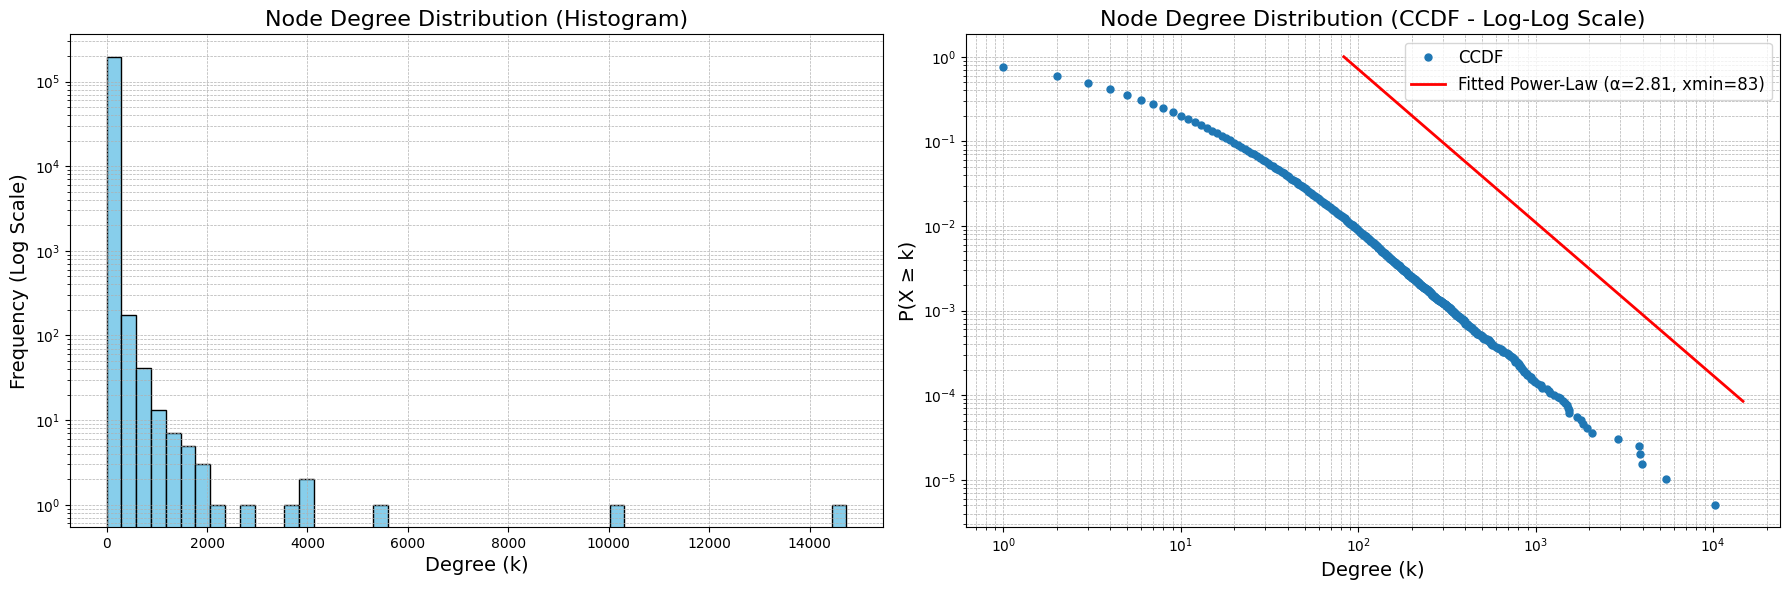

In [35]:
degrees = [G.degree(n) for n in G.nodes()]
plot_distribution(degrees, 'Node Degree Distribution', 'Degree (k)', show_powerlaw=True)

#### Insights

**Size**  
With ~200 000 nodes (users) and ~1 000 000 connections (friendships between users) this is an extremely sparse network.

**Connected Components**  
The entire network is a single connected component, which is somewhat unusual to have in a social network. The data, as reported in the SNAP dedicated page, has been collected from the Gowalla public API, and is not reported if the dataset include only a connected component. According to sources<sup>[[1][1]] [[2][2]]</sup>, by late 2010 Gowalla had approximately 600 000 members, which could confirm the hypothesis that the dataset is reporting only a connected component (probably the largest). Further investigation will be done by inspecting the number of edges of new users over time. <span style="color:yellow">(TODO)</span>

[1]: https://web.archive.org/web/20101205020126/http://content.usatoday.com/communities/technologylive/post/2010/12/the-latest-from-gowalla-is-worth-checking-out/1
[2]: https://en.wikipedia.org/wiki/Gowalla

**Degree**  
The degree analysis reported an heavy-tailed degree distribution with many users that have a low degree and some hubs that have over 10 000 connections. The Complementary Cumulative Distribution Function (CCDF) with Log-Log scale plotted a straight line, confirming the presence of a power law (for degree values >= 83).

**Clustering**  
There is a moderate (~23%) probability that two friends of a user are also friends with each other, confirming the presence of tight local cluster, while the global structure is loosely connected.

**Distances**  
A diameter of 14 and a 90th percentile of ~6 indicates the presence of a small-world property.

### Check-Ins

In [36]:
print(df.head(10))

   user         check-in_datetime   latitude  longitude  location_id
0     0 2010-10-19 23:55:27+00:00  30.235909 -97.795140        22847
1     0 2010-10-18 22:17:43+00:00  30.269103 -97.749395       420315
2     0 2010-10-17 23:42:03+00:00  30.255731 -97.763386       316637
3     0 2010-10-17 19:26:05+00:00  30.263418 -97.757597        16516
4     0 2010-10-16 18:50:42+00:00  30.274292 -97.740523      5535878
5     0 2010-10-12 23:58:03+00:00  30.261599 -97.758581        15372
6     0 2010-10-12 22:02:11+00:00  30.267910 -97.749312        21714
7     0 2010-10-12 19:44:40+00:00  30.269103 -97.749395       420315
8     0 2010-10-12 15:57:20+00:00  30.281120 -97.745211       153505
9     0 2010-10-12 15:19:03+00:00  30.269103 -97.749395       420315


In [37]:
print(f'DataFrame with {df.shape[0]} rows and {df.shape[1]} columns')

print('\nColumns datatypes:')
print(df.dtypes)

DataFrame with 6442892 rows and 5 columns

Columns datatypes:
user                               int64
check-in_datetime    datetime64[ns, UTC]
latitude                         float64
longitude                        float64
location_id                        int64
dtype: object


In [38]:
df.isna().sum()

user                 0
check-in_datetime    0
latitude             0
longitude            0
location_id          0
dtype: int64

In [6]:
locations_df = df["location_id"].unique()

print(f'There are {len(locations_df)} unique locations.')

There are 1280969 unique locations.


---

---

---

In [6]:
df['coords'] = list(zip(df['latitude'], df['longitude']))

In [10]:
unique_coords_for_each_location = df.groupby('location_id')['coords'].nunique().loc[lambda x: x != 1]
unique_location_for_each_coord = df.groupby('coords')['location_id'].nunique().loc[lambda x: x != 1]

print(f'There are {unique_coords_for_each_location.shape[0]} location with multiple coordinates associated.')
print(f'There are {unique_location_for_each_coord.shape[0]} coordinates with multiple location associated.')

There are 297 location with multiple coordinates associated.
There are 17120 coordinates with multiple location associated.


This finding is critical: there is a many-to-many association between locations and coordinates. This means that at the moment the location is not a perfect information to define a unique physical "place" in the real world.
The reasons behind this discrepancy could be multiple:
- GPS inaccuracy
- If the location is big enough it could have been represented with different coordinates
- Locations could have moved to a different location, resulting in different coordinates over time
- If coordinates are user generated and not linked to a location by Gowalla itself, multiple users could have created multiple coordinates for the same place
- If two locations extend vertically in the same building then they will have the same coordinates

It's also worth to node that each decimal place in a coordinate adds about a magnitude more precision. This means that if each decimal degree is equal to 111 kilometers at the equator, a value in decimal degrees with a precision of 4 decimal places is precise to 11.1 metres at the equator, and a value in decimal degrees with a precision of 10 decimal places is precise to ~11 micrometers at the equator<sup>[[1][1]]</sup>: this is how the data is represented in the dataset. Is safe to say that no GPS has this precision, and the data provided could have been subject to computation artifacts (floating-point).

Whatever the cause is, to calculate the home position of a user we need to have a more robust association between locations and coordinates.

[1]: <https://en.wikipedia.org/wiki/Decimal_degrees#Precision>

In [26]:
df['coords_2_decimals'] = list(zip(np.round(df['latitude'], 0), np.round(df['longitude'], 0)))

In [ ]:
heat_data = [[row['latitude'], row['longitude']] for index, row in df.iterrows()]

map_center = [df['latitude'].mean(), df['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

HeatMap(heat_data, radius=15, blur=10).add_to(m)

m.save("gowalla_heatmap.html")

Number of users with at least one check-in: 107092 (54.47%)
Most active user made 2175 check-ins.
Average user has ~60.16 check-ins.



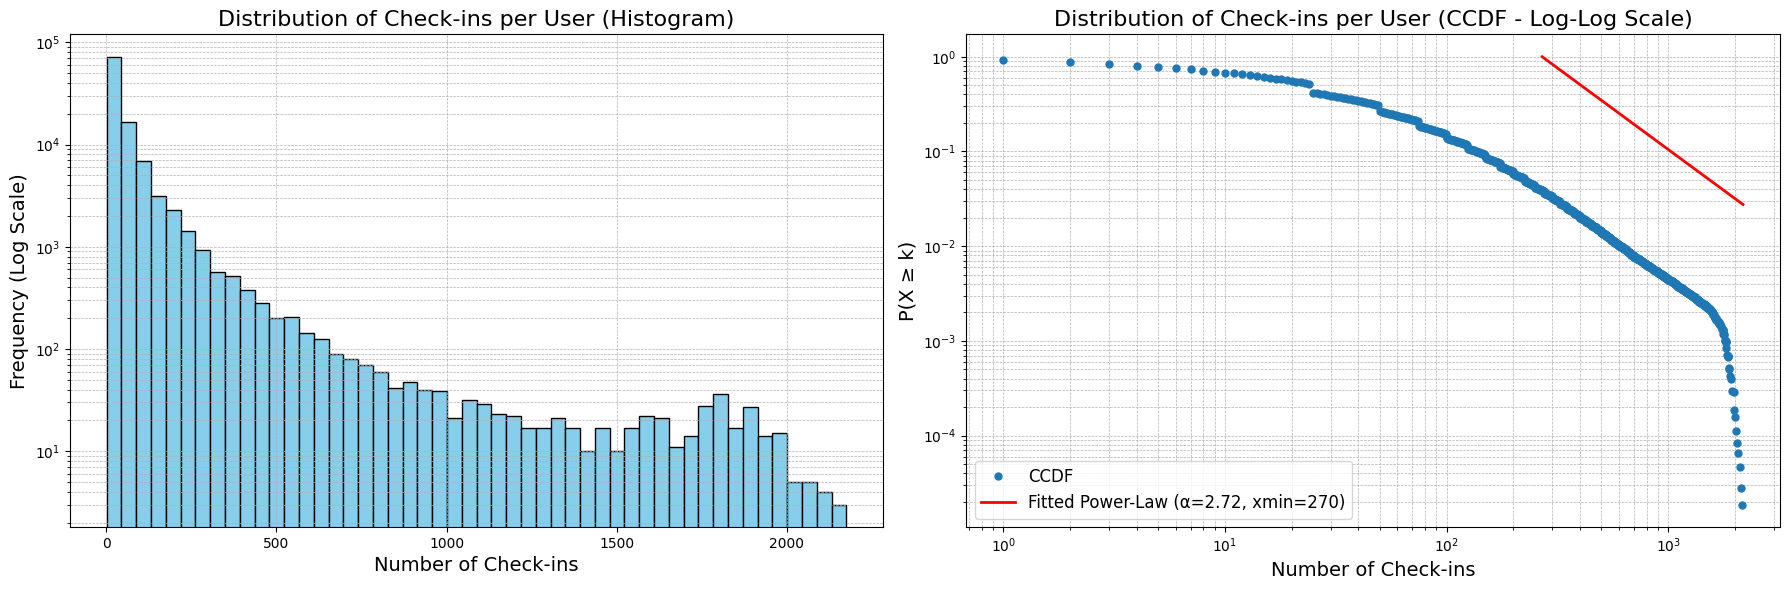

In [ ]:
checkins_per_user = df['user'].value_counts()

print(f'Number of users with at least one check-in: {len(checkins_per_user)} ({len(checkins_per_user)/G.number_of_nodes()*100:.2f}%)')
print(f'Most active user made {checkins_per_user.max()} check-ins.')
print(f'Average user has ~{checkins_per_user.mean():.2f} check-ins.\n')


plot_distribution(
    checkins_per_user,
    'Distribution of Check-ins per User',
    'Number of Check-ins',
    show_powerlaw=True
)

Unique locations:               1280969
Most check-ins for a location:  5811
Average check-ins per location: 5.03
Median check-ins per location:  2.00
Least check-ins for a location: 1




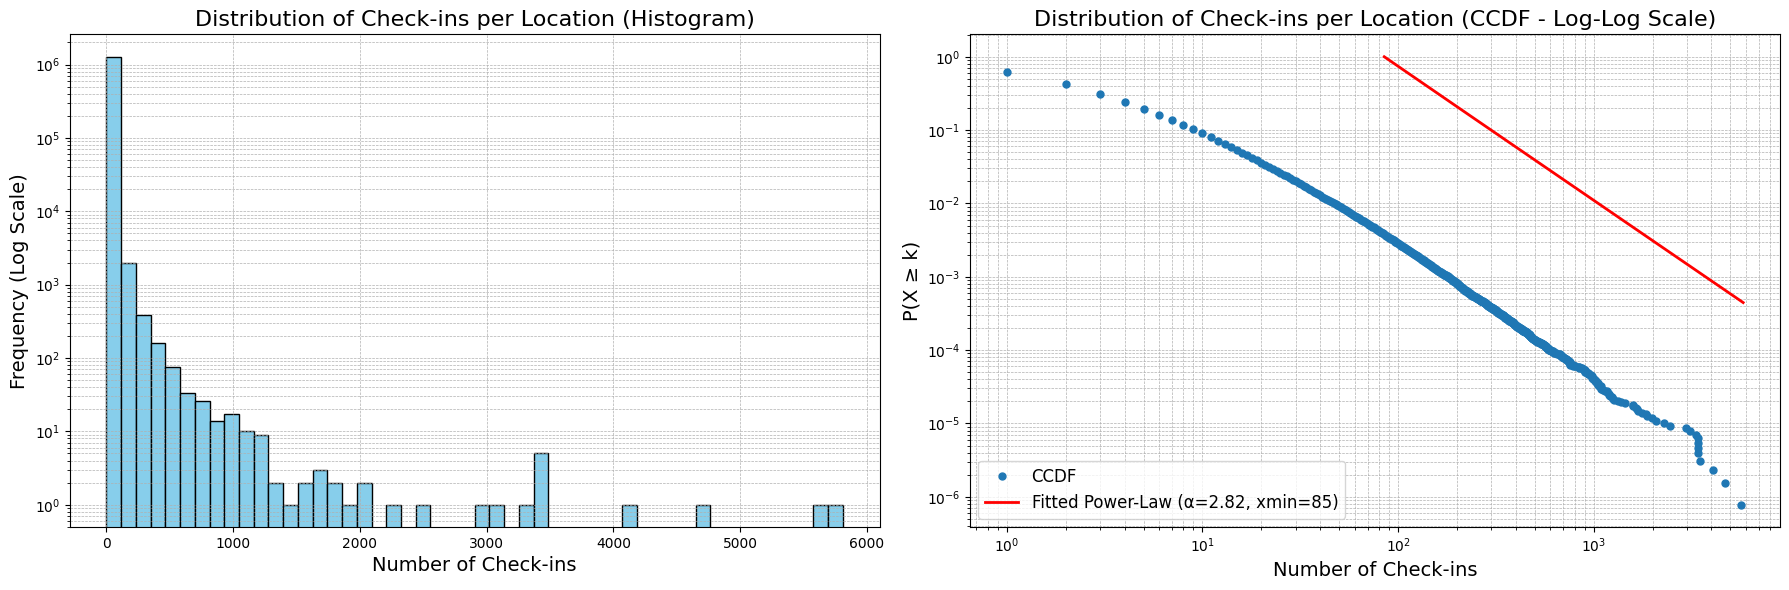

In [ ]:
checkins_per_location = df['location_id'].value_counts()

print(f'Unique locations:               {len(checkins_per_location)}')
print(f'Most check-ins for a location:  {checkins_per_location.max()}')
print(f'Average check-ins per location: {checkins_per_location.mean():.2f}')
print(f'Median check-ins per location:  {checkins_per_location.median():.2f}')
print(f'Least check-ins for a location: {checkins_per_location.min()}')

print('\n')
plot_distribution(
    checkins_per_location,
    'Distribution of Check-ins per Location',
    'Number of Check-ins',
    show_powerlaw=True
)

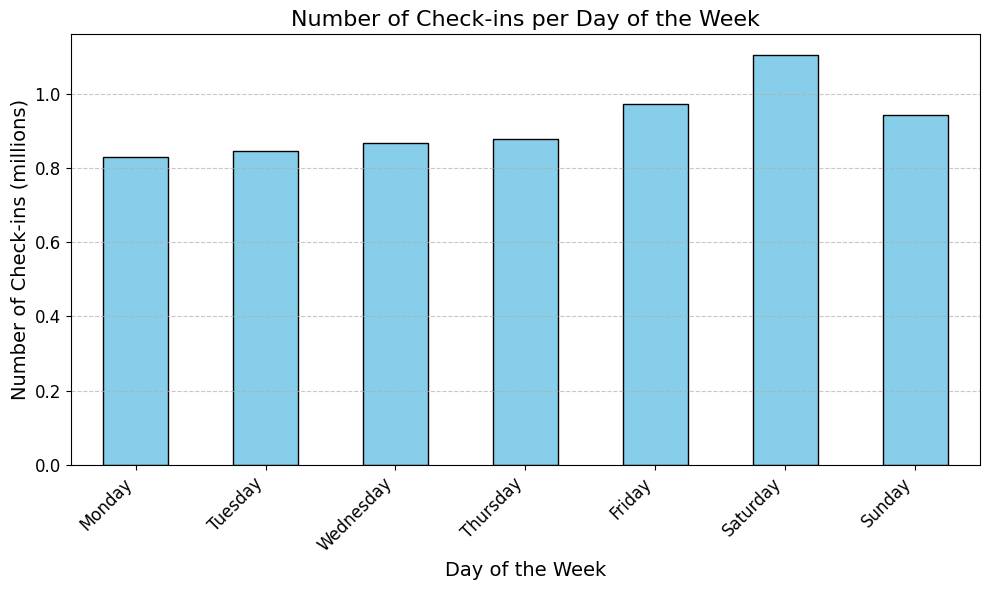

In [14]:
df['day_of_week'] = df['check-in_datetime'].dt.dayofweek

# Count check-ins for each day of the week
checkins_by_day = df['day_of_week'].value_counts().sort_index()
checkins_by_day = checkins_by_day / 1000000
# Map numerical day of week to names for better readability on the plot
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
checkins_by_day.index = [day_names[i] for i in checkins_by_day.index] #type: ignore

# Plotting
plt.figure(figsize=(10, 6))
checkins_by_day.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Number of Check-ins per Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Number of Check-ins (millions)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12) # Rotate labels for readability
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7) # Only horizontal grid lines
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

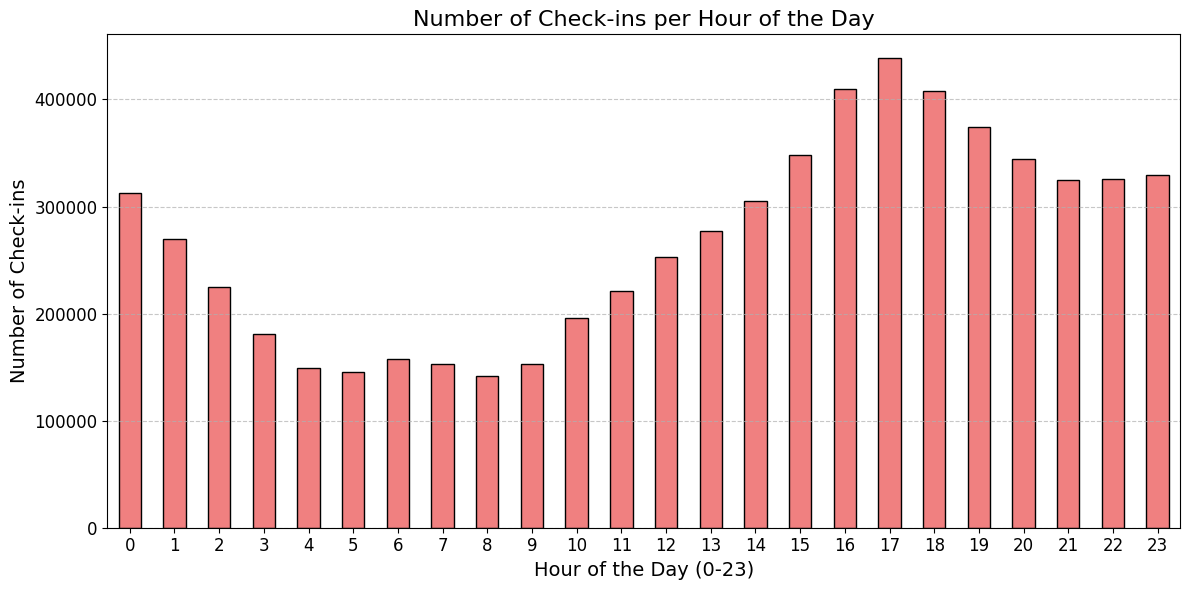

In [ ]:
df['hour_of_day'] = df['check-in_datetime'].dt.hour

# Count check-ins for each hour of the day
checkins_by_hour = df['hour_of_day'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(12, 6))
checkins_by_hour.plot(kind='bar', color='lightcoral', edgecolor='black')

plt.title('Number of Check-ins per Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day (0-23)', fontsize=14)
plt.ylabel('Number of Check-ins', fontsize=14)
plt.xticks(rotation=0, fontsize=12) # No rotation needed for hours
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7) # Only horizontal grid lines
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()